In [55]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy import table
from astropy.visualization import hist as ahist
from astropy.visualization import LogStretch, MinMaxInterval, ManualInterval

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
rcParams['image.cmap'] = 'viridis'

In [3]:
# a fun trick that makes the notebook always be 90% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

# Helper functions

In [4]:
def coo_to_scatter_inputs(coo):
    x = coo.spherical.lon.wrap_at(180*u.deg).rad
    y = coo.spherical.lat.rad
    return np.atleast_1d(x), np.atleast_1d(y)

# First parse/load the data 

In [5]:
import data_loaders

In [6]:
elvii_pairs = data_loaders.load_elvii(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/Burr&Hamilton.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Charybdis&Scylla.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Cher&Sonny.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Kauket&Kek.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Taurus&Orion.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Venus&Serana.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Zeus&Hera.txt


In [7]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [8]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Simulate a GALFA-like survey assuming ELVii are like the LG

### First we produce $M_{HI}$ for everything following Bradford+15

In [9]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [10]:
# produce HI masses for each table
for tab in elvii_pairs.values():
    Ms = tab['Mstar_preferred']
    tab['MHI'] = bradford_15_mstar_to_mgas(Ms)

### Now we populate the tables with equatorial/ICRS coordinates as though these pairs were the real LG

In [11]:
for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


### Then find what the sensitivity would be for a GALFA-like survey from each host in this pair

In [12]:
for tab in elvii_pairs.values():
    for i in (0, 1):
        host_sc = SkyCoord(ra=tab['host{}_lon'.format(i)], 
                           dec=tab['host{}_lat'.format(i)])
        
        pxs = host_sc.to_pixel(galfa_sens_wcs)
        xp = np.round(pxs[0]).astype(int)
        yp = np.round(pxs[1]).astype(int)
        msk = (0<=xp)&(xp<galfa_sens.shape[0])&(0<=yp)&(yp<galfa_sens.shape[1])
        
        sens = np.zeros(len(tab), dtype=galfa_sens.dtype)*galfa_sens.unit
        sens[msk] = galfa_sens[xp[msk], yp[msk]]
        sens[sens==0] = np.inf
        
        tab['closest_sens{}'.format(i)] = sens
        tab['in_survey{}'.format(i)] = np.isfinite(sens)

### Now, compute if 21cm is detectable

In [13]:
for name, tab in elvii_pairs.items():
    MHI = tab['MHI']
    for i in (0, 1):
        sens = tab['closest_sens{}'.format(i)]
        det = sens*tab['host{}_dist'.format(i)]**2 < MHI
        tab['detectable{}'.format(i)] = det

### Now check if   velocity is far enough from MW

In [14]:
# this is from Yong Zheng
from find_vlsr_minmax_allsky import find_vlsr_minmax # accepts degrees l,b

_vect_find_vlsr_minmax = np.vectorize(find_vlsr_minmax)
def vlsr_minmax_wrapped(sc):
    scgal = sc.galactic
    return np.array(_vect_find_vlsr_minmax(scgal.l.degree, scgal.b.degree))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


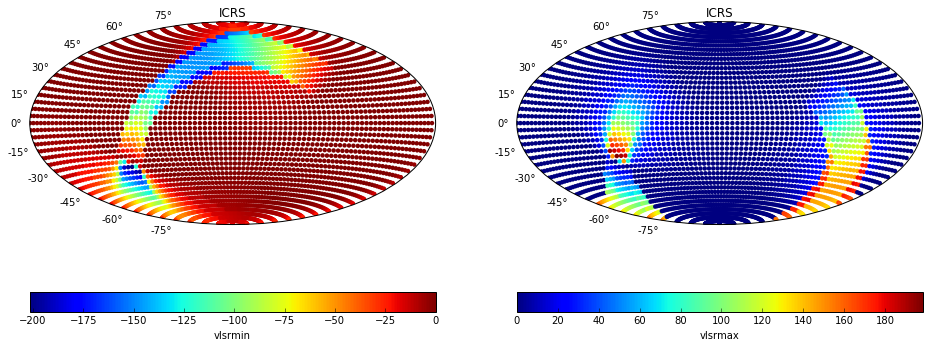

In [15]:
# check that the Vdev derived makes sense
scgrid = SkyCoord(*np.meshgrid(np.linspace(-180, 180, 90), np.linspace(-90, 90, 45))*u.deg)
vlsrmin, vlsrmax = vlsr_minmax_wrapped(scgrid)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1, projection = 'hammer')
plt.scatter(scgrid.ra.wrap_at(180*u.deg).rad, scgrid.dec.rad, c=vlsrmin, lw=0)
plt.title('ICRS')
plt.xticks([])
plt.colorbar(orientation='horizontal').set_label('vlsrmin')

plt.subplot(1,2,2, projection = 'hammer')
plt.scatter(scgrid.ra.wrap_at(180*u.deg).rad, scgrid.dec.rad, c=vlsrmax, lw=0)
plt.title('ICRS')
plt.xticks([])
plt.colorbar(orientation='horizontal').set_label('vlsrmax')

In [16]:
for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        scs = SkyCoord(ra, dec)
        vdevmin, vdevmax = vlsr_minmax_wrapped(scs)*u.km/u.s
        vlsr = tab['host{}_vrlsr'.format(i)]
        tab['host{}_vdevok'.format(i)] = vdevok = (vlsr>vdevmax)|(vdevmin>vlsr)
        print('Host',name.split('&')[i], 'frac vdev ok=',np.sum(vdevok)/len(vdevok), 'of', len(scs))

Host Romulus frac vdev ok= 0.951740506329 of 2528
Host Remus frac vdev ok= 0.916139240506 of 2528
Host Hall frac vdev ok= 0.953407105416 of 1717
Host Oates frac vdev ok= 0.919627256843 of 1717
Host Siegfried frac vdev ok= 0.939382011415 of 5081
Host Roy frac vdev ok= 0.924030702618 of 5081
Host Thelma frac vdev ok= 0.955699940933 of 1693
Host Louise frac vdev ok= 0.904311872416 of 1693
Host Venus frac vdev ok= 0.967889908257 of 4796
Host Serana frac vdev ok= 0.903461217681 of 4796
Host Zeus frac vdev ok= 0.964014191586 of 3946
Host Hera frac vdev ok= 0.953117080588 of 3946
Host Burr frac vdev ok= 0.959098786828 of 2885
Host Hamilton frac vdev ok= 0.942114384749 of 2885
Host Kauket frac vdev ok= 0.968506212077 of 3461
Host Kek frac vdev ok= 0.933545218145 of 3461
Host Lincoln frac vdev ok= 0.943591574438 of 2801
Host Douglas frac vdev ok= 0.927168868261 of 2801
Host Cher frac vdev ok= 0.936681222707 of 2290
Host Sonny frac vdev ok= 0.910480349345 of 2290
Host Charybdis frac vdev ok= 0.9

## Now check if  velocity is far enough from MW HVCs

In [17]:
wakker_hvcs = table.Table.read('wakk.fits')
wakker_hvcs.show_in_notebook(display_length=1)

In [18]:
wakk_scs = SkyCoord(l=wakker_hvcs['L']*u.deg, b=wakker_hvcs['B']*u.deg, frame='galactic')
wakk_scs1 = SkyCoord(l=wakker_hvcs['L'].reshape(len(wakker_hvcs), 1)*u.deg, 
                     b=wakker_hvcs['B'].reshape(len(wakker_hvcs), 1)*u.deg, 
                     frame='galactic')

In [19]:
D_threshold = 25

for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        scs = SkyCoord(ra, dec)
        
        seps = scs.separation(wakk_scs1) # this is now len(wakk) x len(tab)
        dv = tab['host{}_vrlsr'.format(i)] - wakker_hvcs['VLSR'].reshape(len(wakker_hvcs), 1)*(u.km/u.s)
        dHVCs_all = np.sqrt(seps.deg**2 + (dv.to('km/s').value/2.)**2)
        
        tab['host{}_dHVC'.format(i)] = dHVCs = np.min(dHVCs_all, axis=0)
        tab['host{}_dHVCok'.format(i)] = dHVCs > D_threshold
        print('Host',name.split('&')[i], 'frac dHVC ok=',np.sum(dHVCs > 25)/len(dHVCs), 'of', len(scs))

Host Romulus frac dHVC ok= 0.270965189873 of 2528
Host Remus frac dHVC ok= 0.256329113924 of 2528
Host Hall frac dHVC ok= 0.273150844496 of 1717
Host Oates frac dHVC ok= 0.234711706465 of 1717
Host Siegfried frac dHVC ok= 0.294233418618 of 5081
Host Roy frac dHVC ok= 0.322967919701 of 5081
Host Thelma frac dHVC ok= 0.246308328411 of 1693
Host Louise frac dHVC ok= 0.236857649144 of 1693
Host Venus frac dHVC ok= 0.266680567139 of 4796
Host Serana frac dHVC ok= 0.364053377815 of 4796
Host Zeus frac dHVC ok= 0.271414090218 of 3946
Host Hera frac dHVC ok= 0.271414090218 of 3946
Host Burr frac dHVC ok= 0.224956672444 of 2885
Host Hamilton frac dHVC ok= 0.294627383016 of 2885
Host Kauket frac dHVC ok= 0.20109794857 of 3461
Host Kek frac dHVC ok= 0.267841664259 of 3461
Host Lincoln frac dHVC ok= 0.265619421635 of 2801
Host Douglas frac dHVC ok= 0.27740092824 of 2801
Host Cher frac dHVC ok= 0.26768558952 of 2290
Host Sonny frac dHVC ok= 0.294759825328 of 2290
Host Charybdis frac dHVC ok= 0.2594

## Also record which are subs of the hosts

In [20]:
for name, tab in elvii_pairs.items():
    id0, id1 = tab['ID'][:2]
    tab['sat_of_0'] = tab['UpID'] == id0
    tab['sat_of_1'] = tab['UpID'] == id1
    tab['sat_of_either'] = tab['sat_of_0']|tab['sat_of_1']

# Summary figures 

## Findable objects: 

In [21]:
p=elvii_pairs['Siegfried&Roy']

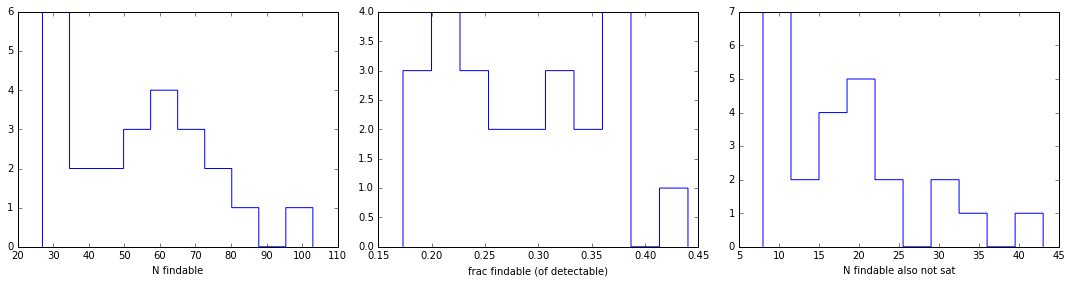

In [71]:
def compute_summaries(detfun=lambda tab, hostidx:tab['detectable{}'.format(hostidx)], 
                      savefindable=False, makehists=True, **histkwargs):
    findables = []
    dets = []
    nonsatfindables = []

    for name, tab in elvii_pairs.items():
        for i in (0, 1):
            #det = tab['detectable{}'.format(i)]
            det = detfun(tab, i)
            dok = tab['host{}_dHVCok'.format(i)]
            vdevok = tab['host{}_vdevok'.format(i)]
            sats = tab['sat_of_either']

            findable = det & dok & vdevok
            if savefindable:
                tab['findable{}'.format(i)] = findable

            findables.append(np.sum(findable))
            dets.append(np.sum(det))
            nonsatfindables.append(np.sum(findable&~sats))
            
    findables, dets, nonsatfindables = np.array((findables, dets, nonsatfindables))
    if makehists:
        plt.subplot(1, 3, 1)
        ahist(findables, histtype='step',**histkwargs)
        plt.xlabel('N findable')

        plt.subplot(1, 3, 2)
        ahist(findables/dets, histtype='step',**histkwargs)
        plt.xlabel('frac findable (of detectable)')

        plt.subplot(1, 3, 3)
        ahist(nonsatfindables, histtype='step',**histkwargs)
        plt.xlabel('N findable also not sat')

    return findables, dets, nonsatfindables

plt.figure(figsize=(15, 4))
resbaseline = compute_summaries(savefindable=True)
plt.tight_layout()

## Now try the same with some of the fiducial surveys 

### 100 sq degrees at 4000 $M_\odot$ sensitivity, *randomly* placed

 {0: 12, 1: 12}

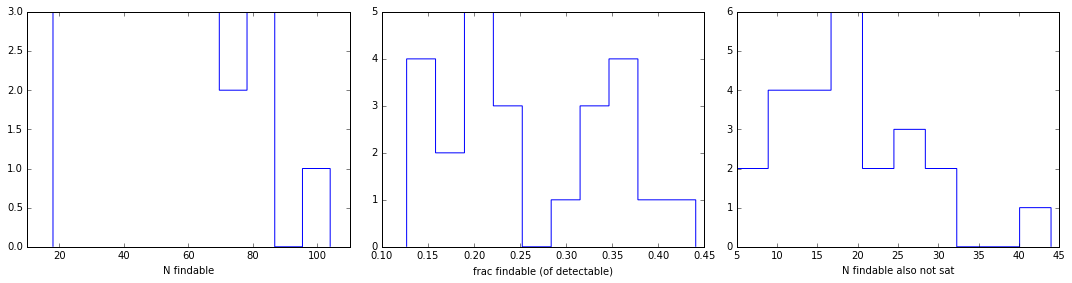

In [67]:
last_galfa_sens_edit100random = [None]  # this is there to *test* that the machinery works
cnt = {0:0, 1:0} #for tracking slow-running progress

def detfun_100sqdeg_random(tab, hostidx):
    #100 sq deg at 4000 M solar sens 
    
    host_sc = SkyCoord(ra=tab['host{}_lon'.format(hostidx)], 
                       dec=tab['host{}_lat'.format(hostidx)])

    pxs = host_sc.to_pixel(galfa_sens_wcs)
    xp = np.round(pxs[0]).astype(int)
    yp = np.round(pxs[1]).astype(int)
    
    galfa_sens_edit = galfa_sens.copy()
    # randomly select 100 sq deg of pixels that are *non-zero* and promote them to 4000 Msun
    npix = 100*60*60
    w1, w2 = np.where(galfa_sens_edit>0)
    toup = np.random.permutation(len(w1))[:npix]
    galfa_sens_edit[(w1[toup], w2[toup])] = 4000*u.Msun*u.Mpc**-2
    last_galfa_sens_edit100random[0] = galfa_sens_edit
    
    msk = (0<=xp)&(xp<galfa_sens_edit.shape[0])&(0<=yp)&(yp<galfa_sens_edit.shape[1])

    sens = np.zeros(len(tab), dtype=galfa_sens_edit.dtype)*galfa_sens_edit.unit
    sens[msk] = galfa_sens_edit[xp[msk], yp[msk]]
    sens[sens==0] = np.inf
    cnt[hostidx]+=1
    print('\r',cnt, end='', flush=True)
    return  sens*tab['host{}_dist'.format(i)]**2 < tab['MHI']
        
plt.figure(figsize=(15, 4))
res100random = compute_summaries(detfun_100sqdeg_random)
plt.tight_layout()

### 100 sq degrees at 4000 $M_\odot$ sensitivity, *near target/M31*

 {0: 12, 1: 12}

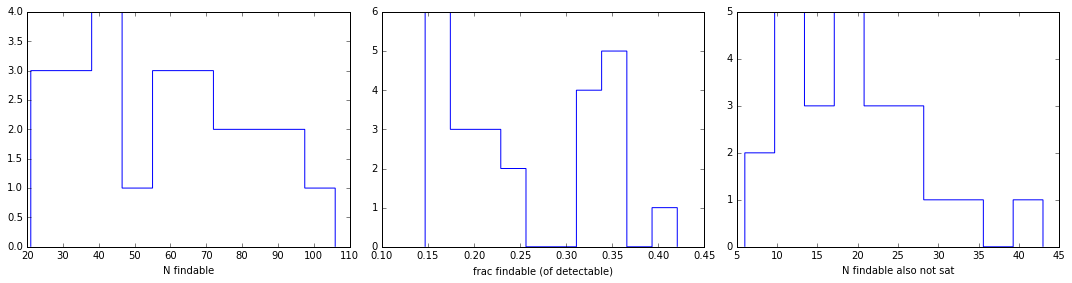

In [68]:
last_galfa_sens_edit100near = [None]  # this is there to *test* that the machinery works
cnt = {0:0, 1:0} #for tracking slow-running progress

def detfun_100sqdeg_near(tab, hostidx):    
    host_sc = SkyCoord(ra=tab['host{}_lon'.format(hostidx)], 
                       dec=tab['host{}_lat'.format(hostidx)])
    targetidx = 1 if hostidx==0 else 0

    pxs = host_sc.to_pixel(galfa_sens_wcs)
    xp = np.round(pxs[0]).astype(int)
    yp = np.round(pxs[1]).astype(int)
    
    galfa_sens_edit = galfa_sens.copy()
    # select 100 sq deg of pixels that are *non-zero* and promote them to 4000 Msun.  Should be the closest ones to the target
    npix = 100*60*60
    w1, w2 = np.where(galfa_sens_edit>0)
    
    #find those with shortest distance from target to pixels in the grid
    xg, yg = np.indices(galfa_sens.shape)
    dxyg = np.hypot(xg - xp[targetidx], yg - yp[targetidx])
    toup = np.argsort(dxyg[w1, w2])[:npix]
    
    galfa_sens_edit[(w1[toup], w2[toup])] = 4000*u.Msun*u.Mpc**-2
    last_galfa_sens_edit100near[0] = galfa_sens_edit
    
    msk = (0<=xp)&(xp<galfa_sens_edit.shape[0])&(0<=yp)&(yp<galfa_sens_edit.shape[1])

    sens = np.zeros(len(tab), dtype=galfa_sens_edit.dtype)*galfa_sens_edit.unit
    sens[msk] = galfa_sens_edit[xp[msk], yp[msk]]
    sens[sens==0] = np.inf
    cnt[hostidx]+=1
    print('\r',cnt, end='', flush=True)
    return  sens*tab['host{}_dist'.format(i)]**2 < tab['MHI']
        
plt.figure(figsize=(15, 4))
res100near = compute_summaries(detfun_100sqdeg_near)
plt.tight_layout()

### 1000 sq degrees at 12000 $M_\odot$ sensitivity, *randomly* placed

 {0: 12, 1: 12}

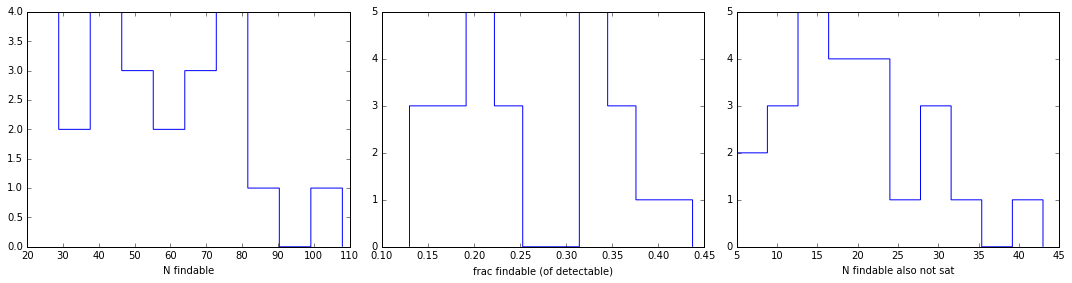

In [69]:
last_galfa_sens_edit1000random = [None]  # this is there to *test* that the machinery works
cnt = {0:0, 1:0}

def detfun_1000sqdeg_random(tab, hostidx):
    #1000 sq deg at 12000 M solar sens 
    
    host_sc = SkyCoord(ra=tab['host{}_lon'.format(hostidx)], 
                       dec=tab['host{}_lat'.format(hostidx)])

    pxs = host_sc.to_pixel(galfa_sens_wcs)
    xp = np.round(pxs[0]).astype(int)
    yp = np.round(pxs[1]).astype(int)
    
    galfa_sens_edit = galfa_sens.copy()
    # randomly select 100 sq deg of pixels that are *non-zero* and promote them to 4000 Msun
    npix = 1000*60*60
    w1, w2 = np.where(galfa_sens_edit>0)
    toup = np.random.permutation(len(w1))[:npix]
    galfa_sens_edit[(w1[toup], w2[toup])] = 12000*u.Msun*u.Mpc**-2
    last_galfa_sens_edit1000random[0] = galfa_sens_edit
    
    msk = (0<=xp)&(xp<galfa_sens_edit.shape[0])&(0<=yp)&(yp<galfa_sens_edit.shape[1])

    sens = np.zeros(len(tab), dtype=galfa_sens_edit.dtype)*galfa_sens_edit.unit
    sens[msk] = galfa_sens_edit[xp[msk], yp[msk]]
    sens[sens==0] = np.inf
    cnt[hostidx]+=1
    print('\r',cnt, end='', flush=True)
    return  sens*tab['host{}_dist'.format(i)]**2 < tab['MHI']
        
plt.figure(figsize=(15, 4))
res1000random = compute_summaries(detfun_1000sqdeg_random)
plt.tight_layout()

### 1000 sq degrees at 12000 $M_\odot$ sensitivity, *near target/M31*

 {0: 12, 1: 12}

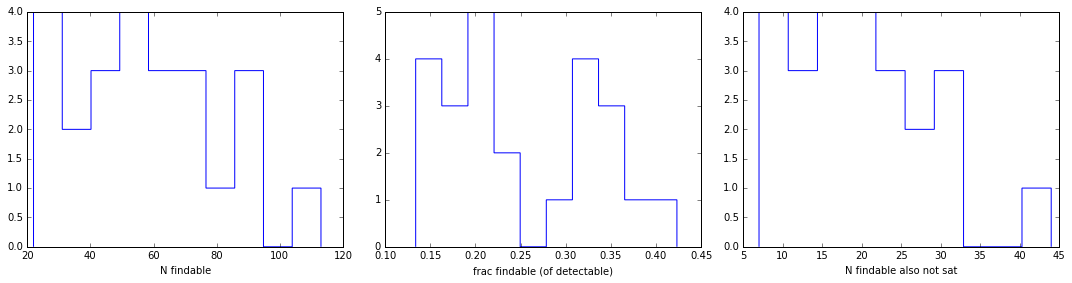

In [70]:
last_galfa_sens_edit1000near = [None]  # this is there to *test* that the machinery works
cnt = {0:0, 1:0} #for tracking slow-running progress

def detfun_1000sqdeg_near(tab, hostidx):    
    host_sc = SkyCoord(ra=tab['host{}_lon'.format(hostidx)], 
                       dec=tab['host{}_lat'.format(hostidx)])
    targetidx = 1 if hostidx==0 else 0

    pxs = host_sc.to_pixel(galfa_sens_wcs)
    xp = np.round(pxs[0]).astype(int)
    yp = np.round(pxs[1]).astype(int)
    
    galfa_sens_edit = galfa_sens.copy()
    # select 1000 sq deg of pixels that are *non-zero* and promote them to 12000 Msun.  Should be the closest ones to the target
    npix = 1000*60*60
    w1, w2 = np.where(galfa_sens_edit>0)
    
    #find those with shortest distance from target to pixels in the grid
    xg, yg = np.indices(galfa_sens.shape)
    dxyg = np.hypot(xg - xp[targetidx], yg - yp[targetidx])
    toup = np.argsort(dxyg[w1, w2])[:npix]
    
    galfa_sens_edit[(w1[toup], w2[toup])] = 12000*u.Msun*u.Mpc**-2
    last_galfa_sens_edit1000near[0] = galfa_sens_edit
    
    msk = (0<=xp)&(xp<galfa_sens_edit.shape[0])&(0<=yp)&(yp<galfa_sens_edit.shape[1])

    sens = np.zeros(len(tab), dtype=galfa_sens_edit.dtype)*galfa_sens_edit.unit
    sens[msk] = galfa_sens_edit[xp[msk], yp[msk]]
    sens[sens==0] = np.inf
    cnt[hostidx]+=1
    print('\r',cnt, end='', flush=True)
    return  sens*tab['host{}_dist'.format(i)]**2 < tab['MHI']
        
plt.figure(figsize=(15, 4))
res1000near = compute_summaries(detfun_1000sqdeg_near)
plt.tight_layout()

### All in one 

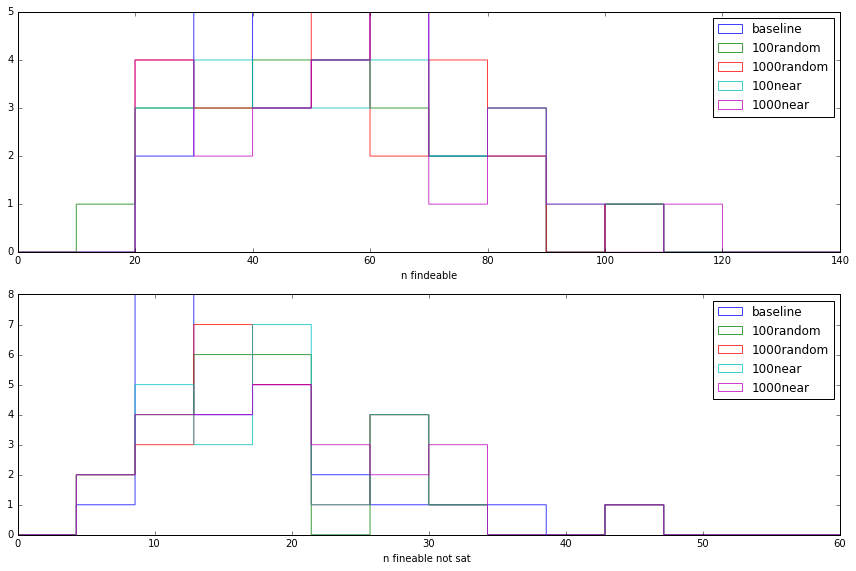

In [92]:
plt.figure(figsize=(12,8))

bins1 = np.linspace(0,140, 15)
bins2 = np.linspace(0,60, 15)

for resnm in 'resbaseline,res100random,res1000random,res100near,res1000near'.split(','):
    res = locals()[resnm]
    findables = res[0]
    findablesnotsat = res[-1]
    
    plt.subplot(2,1,1)
    ahist(findables, label=resnm[3:], histtype='step', bins=bins1, alpha=.75)
    
    plt.subplot(2,1,2)
    ahist(findablesnotsat, label=resnm[3:], histtype='step', bins=bins2, alpha=.75)
    
plt.subplot(2,1,1)
plt.legend(loc=0)
plt.xlabel('n findeable')

plt.subplot(2,1,2)
plt.legend(loc=0)
plt.xlabel('n fineable not sat ')

plt.tight_layout()

## Velocity histograms 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


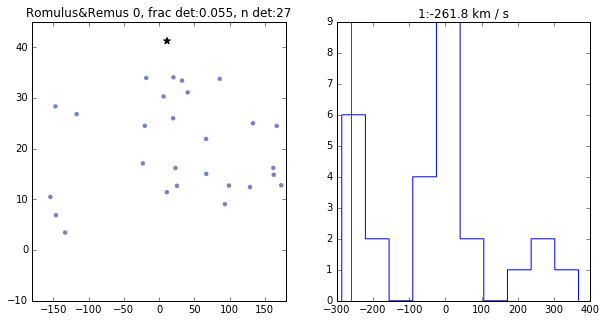

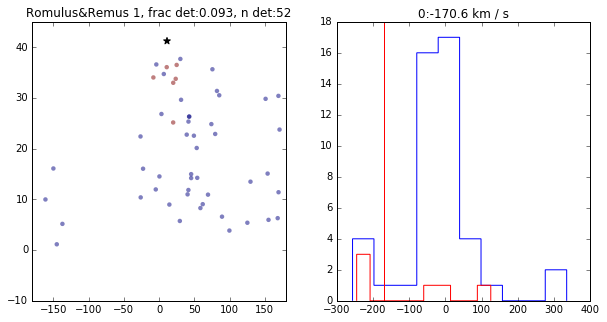

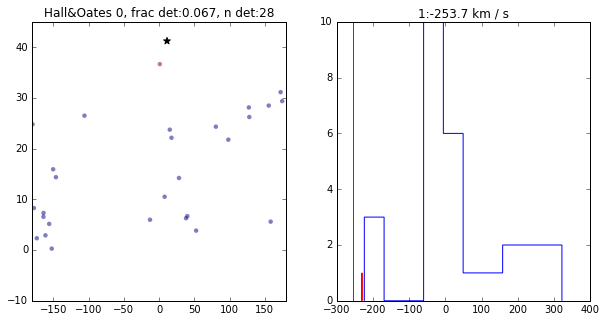

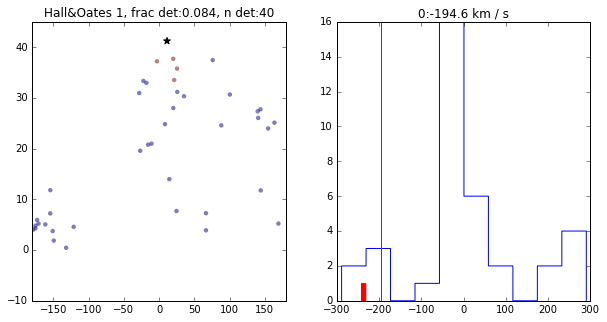

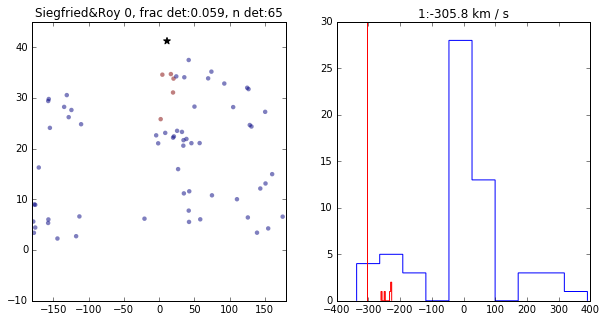

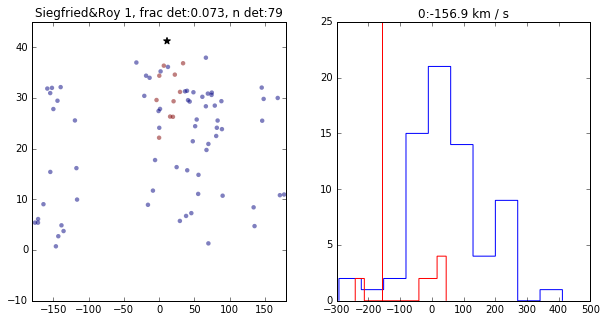

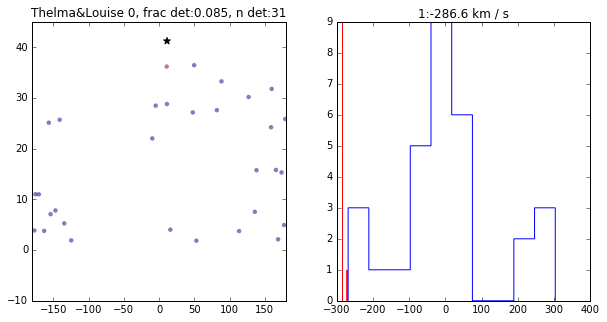

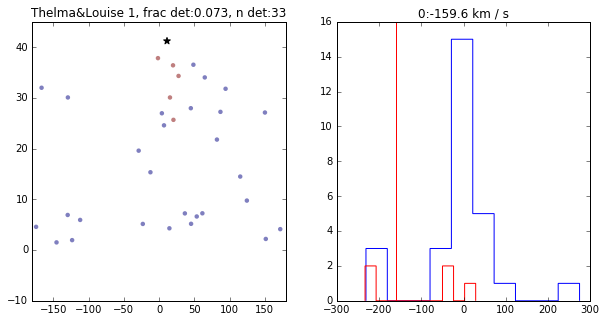

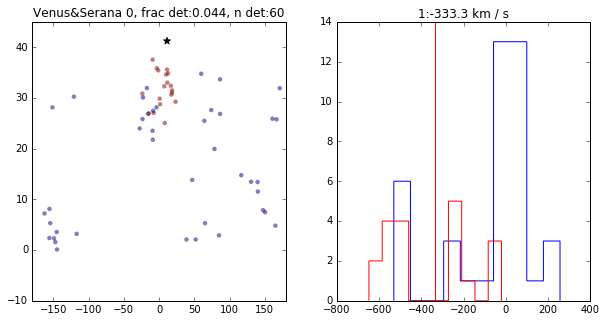

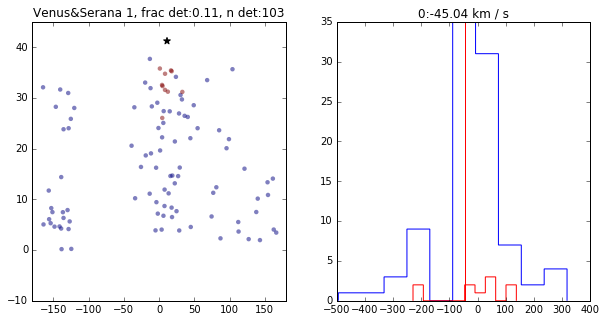

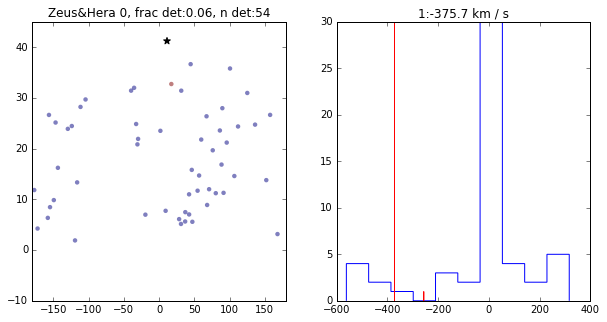

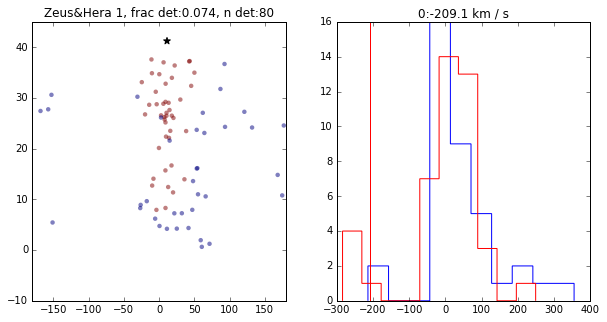

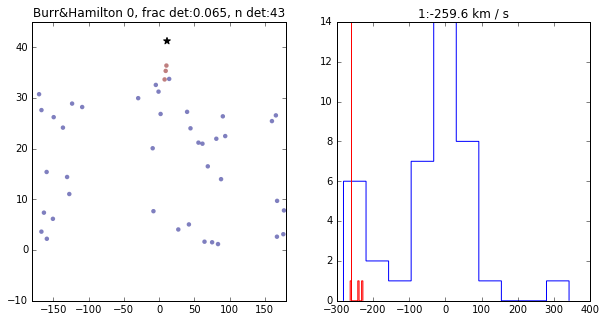

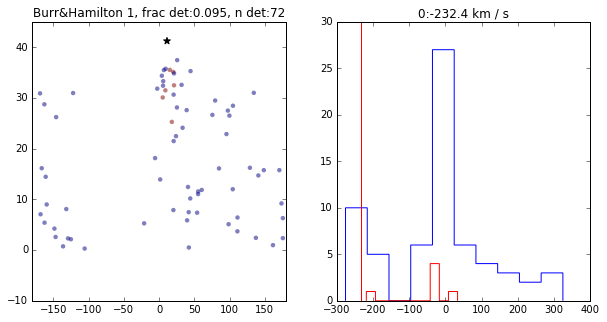

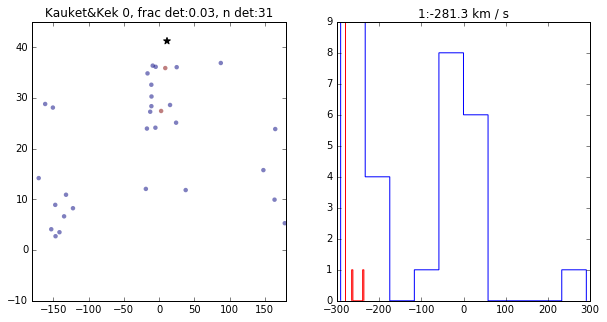

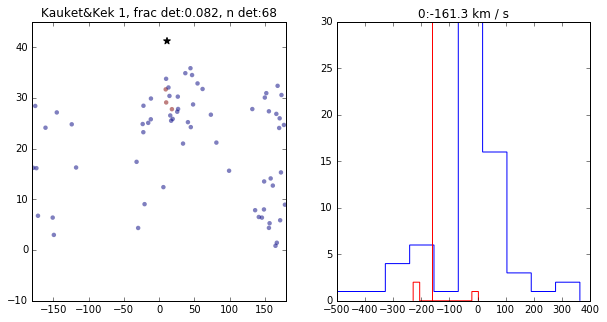

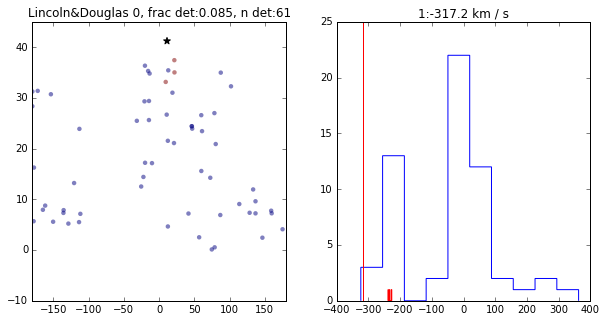

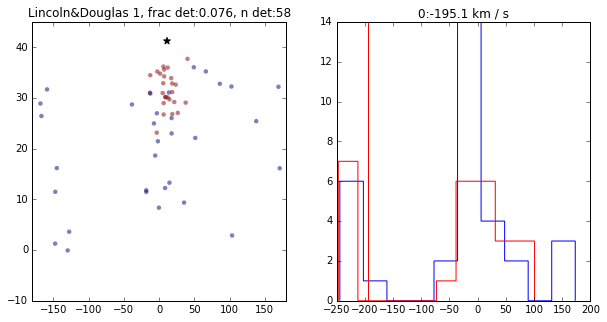

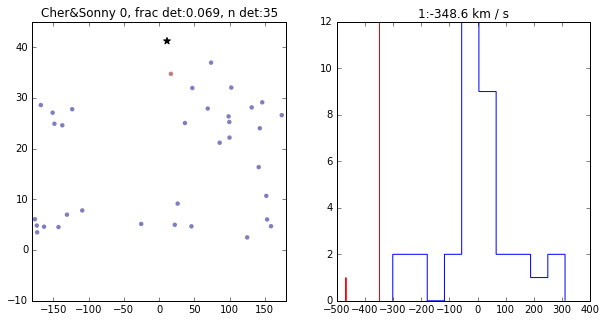

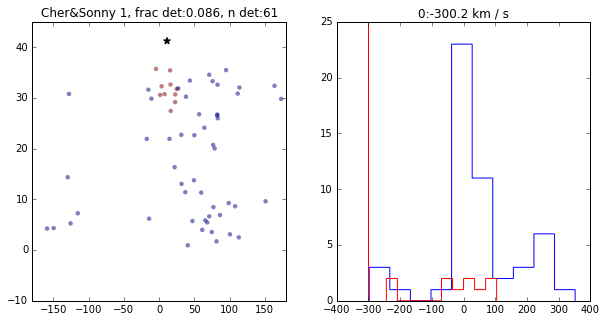

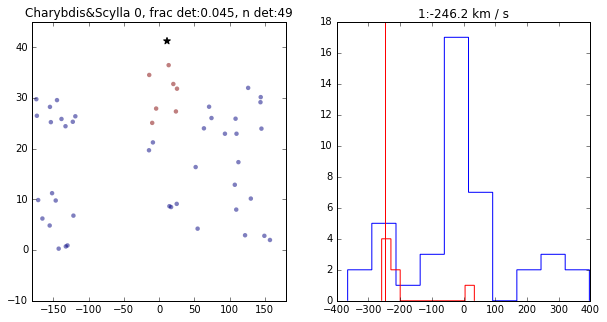

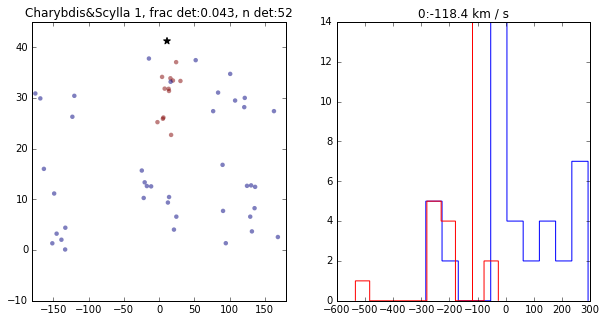

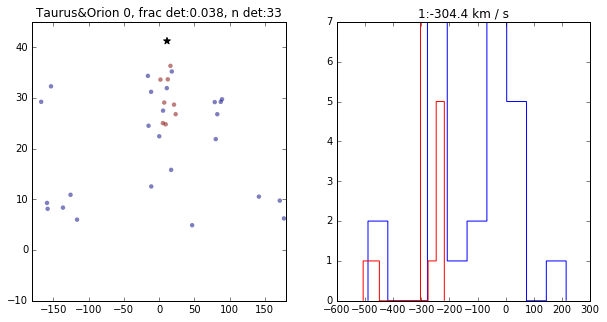

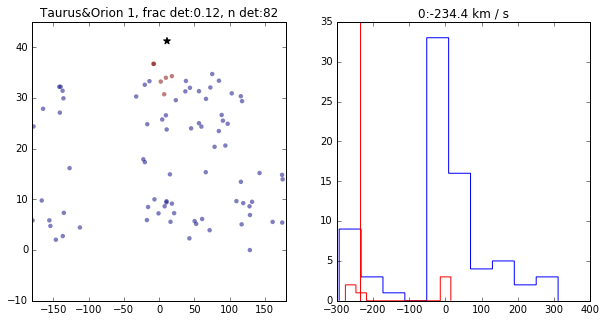

In [29]:
for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        insurv = tab['in_survey{}'.format(i)]
        det = tab['findable{}'.format(i)]
        
        fracdet = np.sum(det)/np.sum(insurv)
        
        
        otheridx = 1 if i==0 else 0
        x, y, z = tab['X'], tab['Y'], tab['Z']
        dother = ((x-x[otheridx])**2+(y-y[otheridx])**2+(z-z[otheridx])**2)**0.5
        inrvir = dother < tab['Rvir'][otheridx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1,2, 1)
        plt.scatter(ra[det].wrap_at(180*u.deg).deg, dec[det].deg, c=inrvir[det],lw=0, alpha=.5)
        plt.scatter(ra[otheridx].wrap_at(180*u.deg).deg, dec[otheridx].deg, color='k', alpha=1, marker='*', s=50)
        plt.title('{} {}, frac det:{:.2}, n det:{}'.format(name, i, fracdet, np.sum(det)))
        plt.xlim(-180, 180)
        plt.ylim(-10, 45)
        
        plt.subplot(1,2, 2)
        vr = tab['host{}_vrlsr'.format(i)]
        plt.hist(vr[det&~inrvir].value, color='b', histtype='step')
        plt.hist(vr[det&inrvir].value, color='r', histtype='step')
        plt.axvline(vr[otheridx].value, c='r')
        plt.title('{}:{:.4}'.format(otheridx, vr[otheridx]))

## On-sky maps of detectable/non-detectable 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


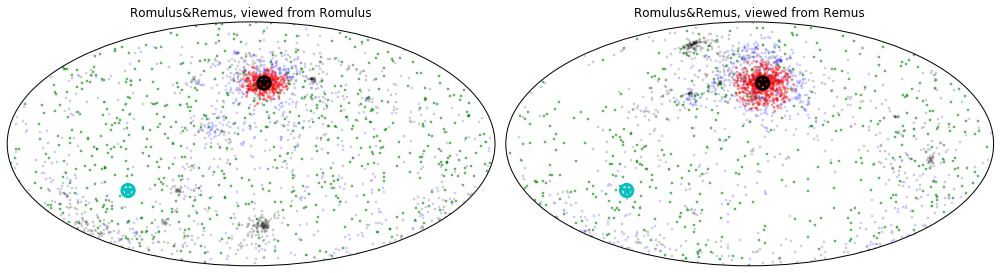

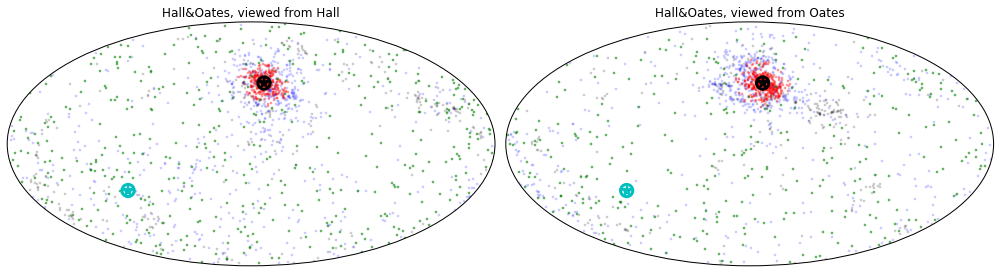

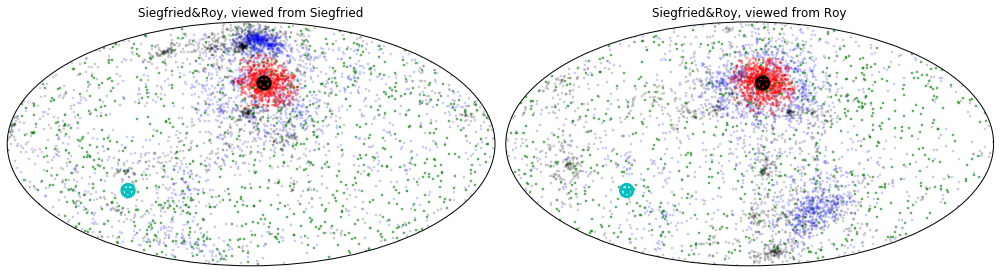

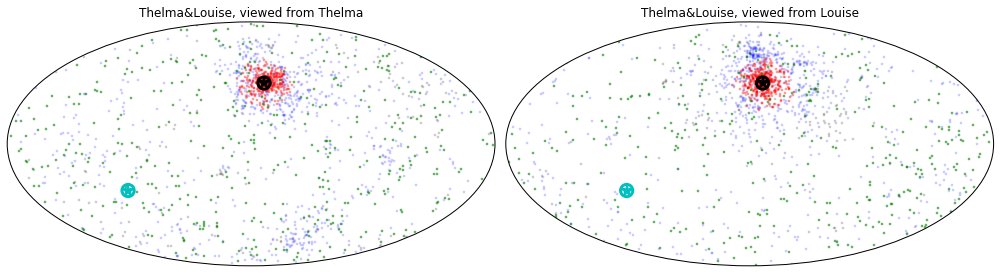

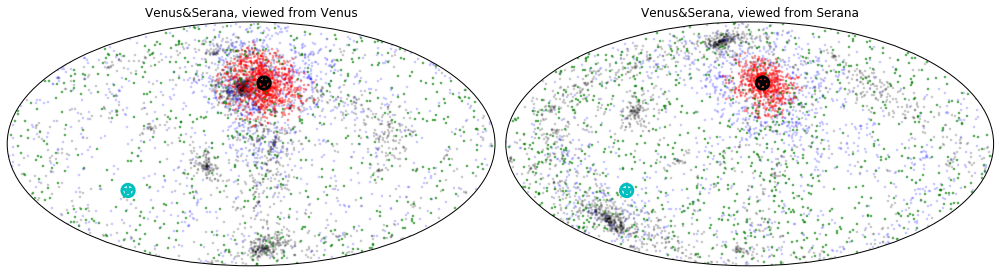

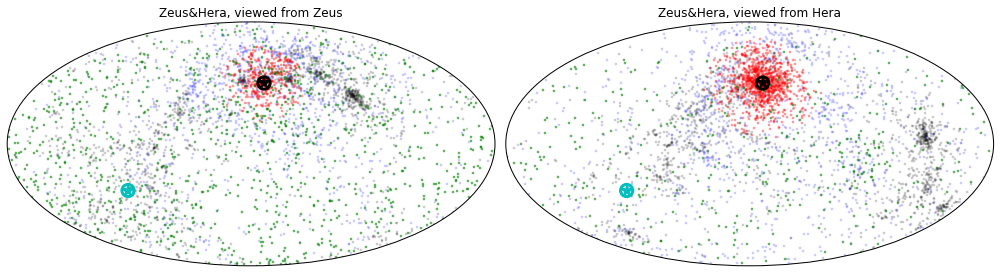

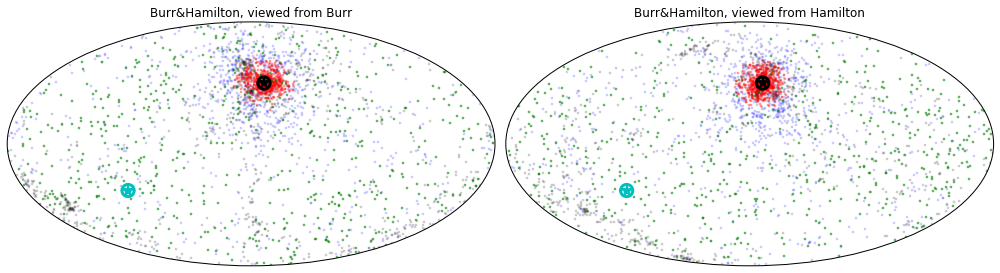

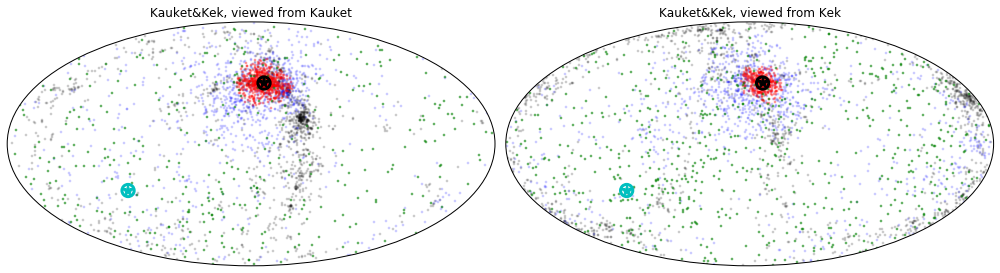

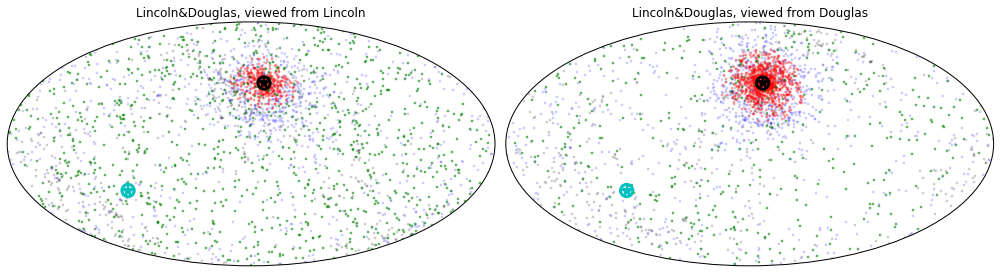

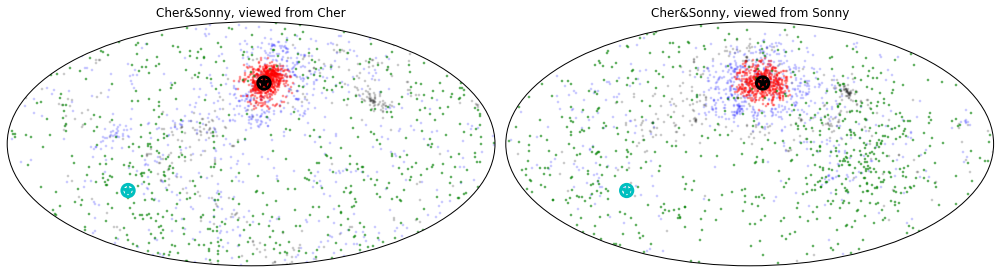

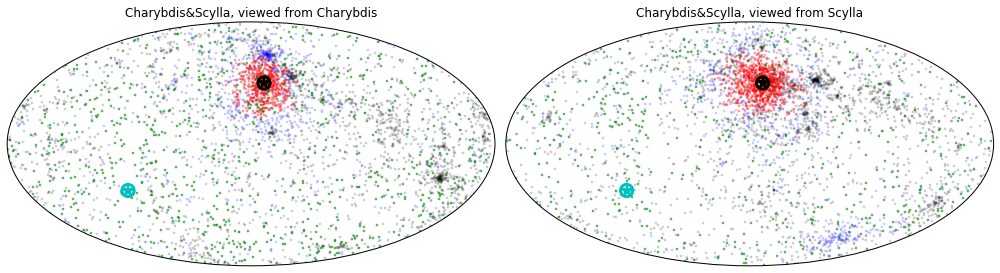

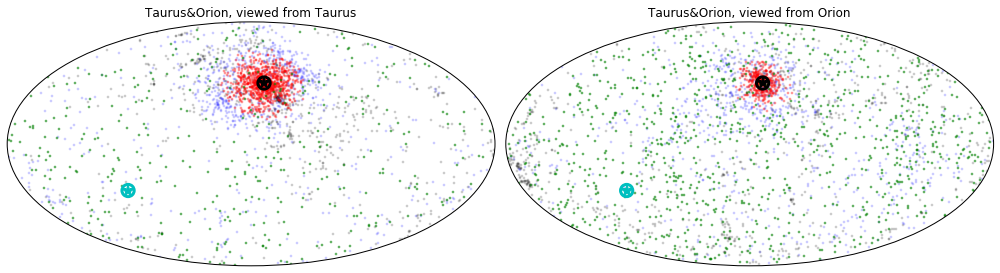

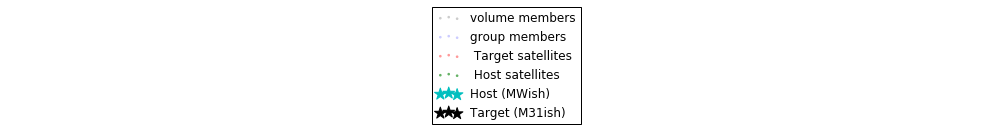

In [30]:
for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        hostidx = i
        otheridx = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))

        ax = plt.subplot(1,2,i+1, projection='hammer')

        #the plot information and plots of actual subs
        sats = [tab['sat_of_0'], tab['sat_of_1']]
        nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)
        msk0 = ~(sats[hostidx]|sats[otheridx]|nearboth)
        msk2 = sats[otheridx]
        msk3 = sats[hostidx]
        msk1 = ~(msk0|msk2|msk3)
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=7, alpha=.2, lw=0, label='volume members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='b',s=7, alpha=.2, lw=0, label='group members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='r',s=7, alpha=.4, lw=0, label=' Target satellites')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=7, alpha=.6, lw=0, label=' Host satellites')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheridx]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


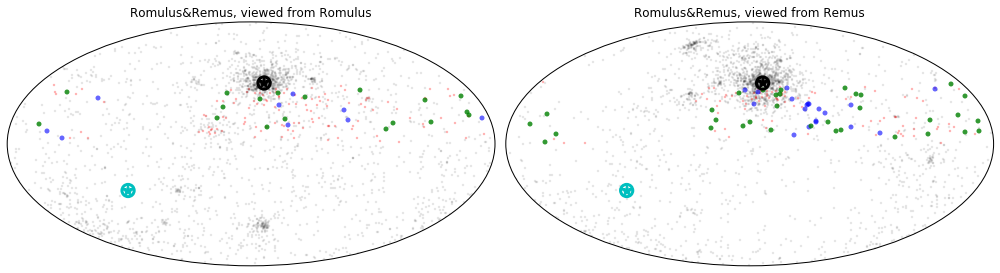

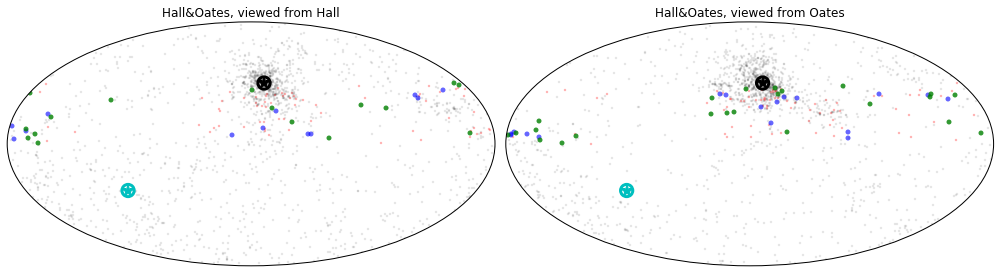

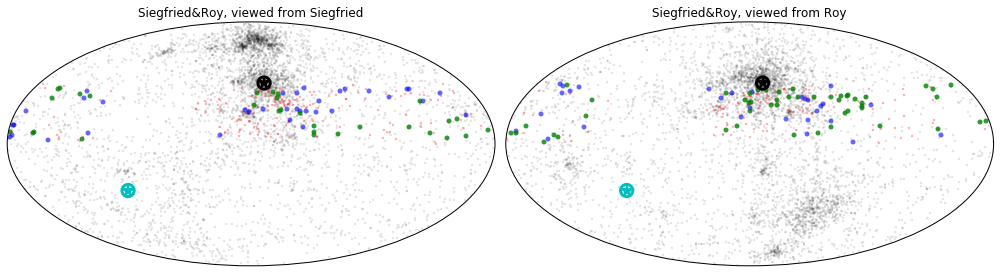

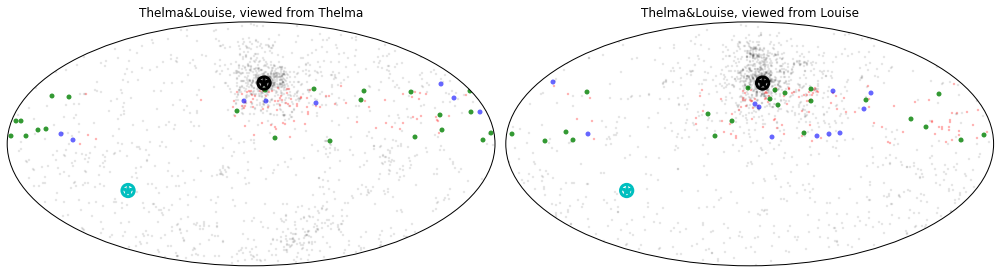

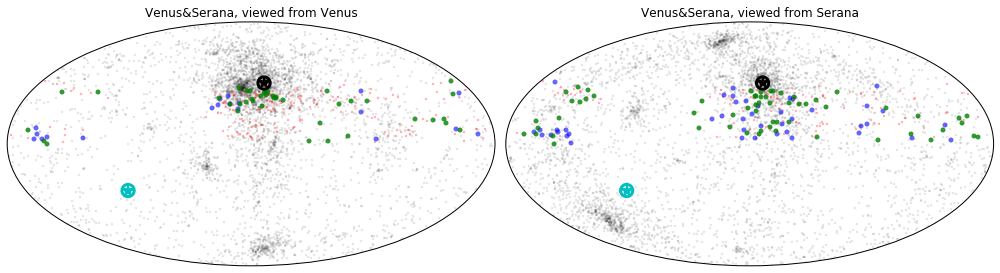

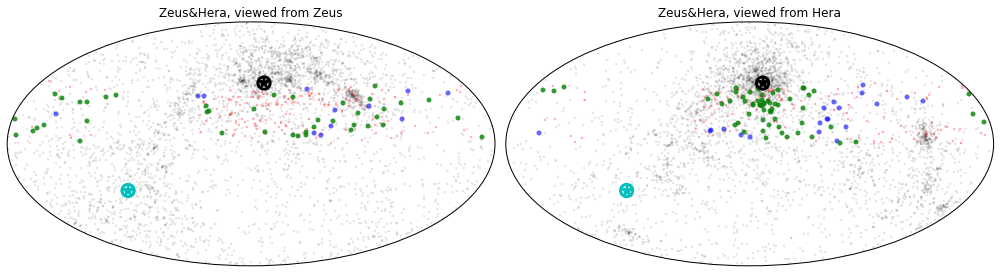

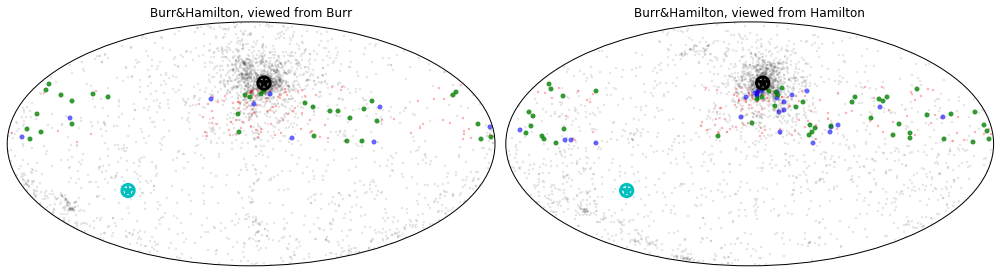

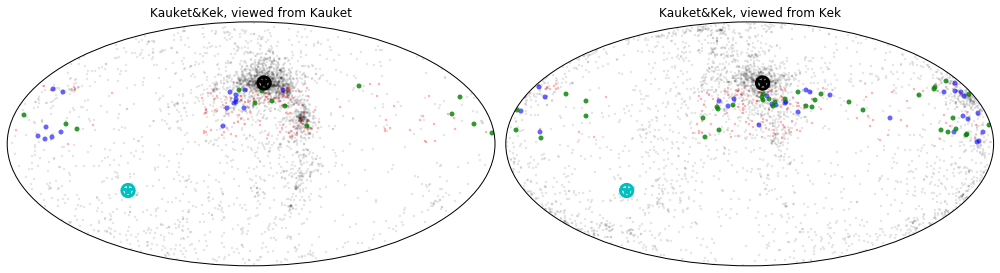

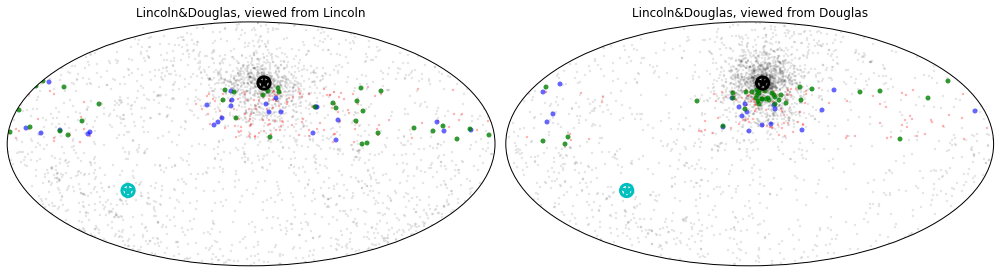

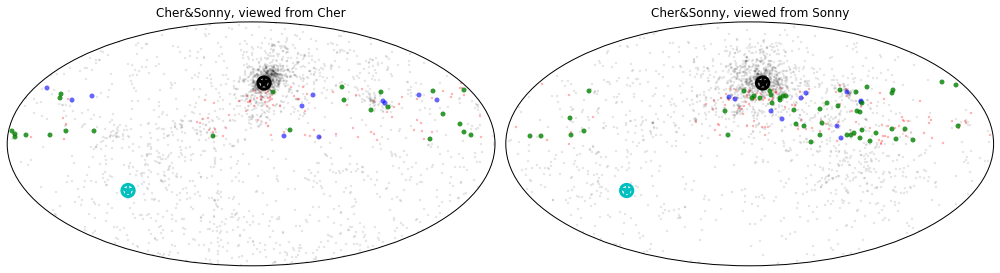

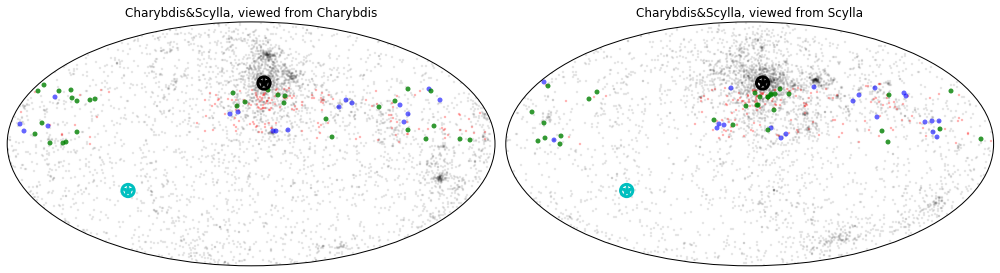

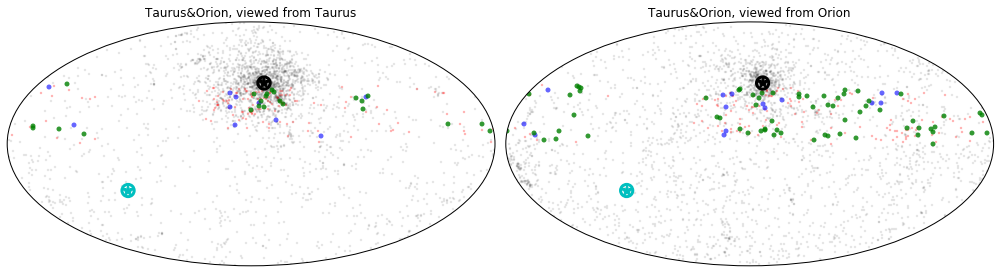

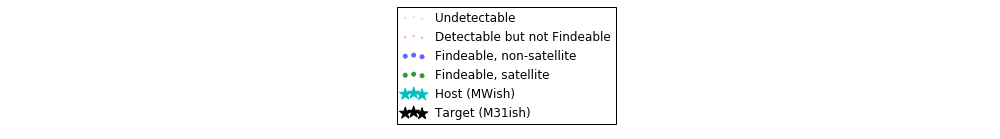

In [31]:
for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        hostidx = i
        otheridx = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))

        ax = plt.subplot(1,2,i+1, projection='hammer')

        #the plot information and plots of actual subs
        det = tab['detectable{}'.format(hostidx)]
        find = tab['findable{}'.format(hostidx)]
        msk0 = ~det
        msk1 = det&~find
        msk2 = find&~tab['sat_of_either']
        msk3 = find&tab['sat_of_either']
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=6, alpha=.1, lw=0, label='Undetectable')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='r',s=6, alpha=.3, lw=0, label='Detectable but not Findeable')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='b',s=25, alpha=.6, lw=0, label='Findeable, non-satellite')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=25, alpha=.8, lw=0, label='Findeable, satellite')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheridx]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

### Relative velocities of the host halos

In [32]:
for name, tab in elvii_pairs.items():
    dx = tab['X'][1] - tab['X'][0]
    dy = tab['Y'][1] - tab['Y'][0]
    dz = tab['Z'][1] - tab['Z'][0]
    d = (dx**2 + dy**2 + dz**2)**0.5
    
    dvx = tab['Vx'][1] - tab['Vx'][0]
    dvy = tab['Vy'][1] - tab['Vy'][0]
    dvz = tab['Vz'][1] - tab['Vz'][0]
    vsep = (dvx*dx + dvy*dy + dvz*dz)/d
    
    print(name , '{:.4}'.format(d.to(u.kpc)), '{:.4}'.format(vsep.to(u.km/u.s)))

Romulus&Remus 935.4 kpc -86.78 km / s
Hall&Oates 979.5 kpc -78.48 km / s
Siegfried&Roy 877.6 kpc -130.8 km / s
Thelma&Louise 832.2 kpc -111.5 km / s
Venus&Serana 687.4 kpc -157.8 km / s
Zeus&Hera 595.2 kpc -200.7 km / s
Burr&Hamilton 941.3 kpc -84.83 km / s
Kauket&Kek 1.04e+03 kpc -106.1 km / s
Lincoln&Douglas 780.4 kpc -142.0 km / s
Cher&Sonny 966.2 kpc -173.5 km / s
Charybdis&Scylla 705.1 kpc -71.16 km / s
Taurus&Orion 829.3 kpc -128.7 km / s


# 3D plots for a selected host

In [33]:
# for interactive 3D plot
# %matplotlib nbagg

In [34]:
hostname = 'Roy'

dobreak = False
for tname, tab in elvii_pairs.items():
    names = tname.split('&')
    for i, name in enumerate(names):
        if name==hostname:
            #tab already set
            othername = names[0] if i else names[1]
            hostidx = i
            otheridx = 1 if i==0 else 0
            dobreak = True
    if dobreak:
        break
else:
    del tab, hostidx
    raise ValueError('Could not find host ' + hostname)
    
axlims = [(-1.5, 1.5)]*3

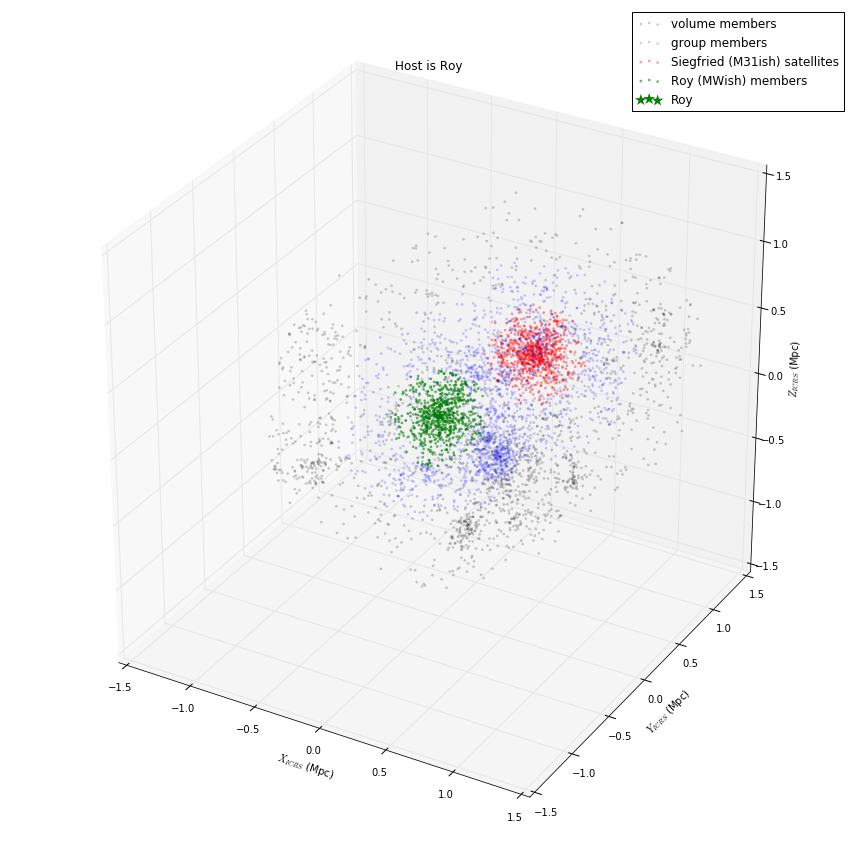

In [35]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

sats = [tab['sat_of_0'], tab['sat_of_1']]
nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)


plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~(sats[hostidx]|sats[otheridx]|nearboth)
msk2 = sats[otheridx]
msk3 = sats[hostidx]
msk1 = ~(msk0|msk2|msk3)

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=7, alpha=.2, lw=0, label='volume members')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='b',s=7, alpha=.2, lw=0, label='group members')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='r',s=7, alpha=.4, lw=0, label=othername + ' (M31ish) satellites')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=7, alpha=.6, lw=0, label=hostname + ' (MWish) members')
ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)


ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

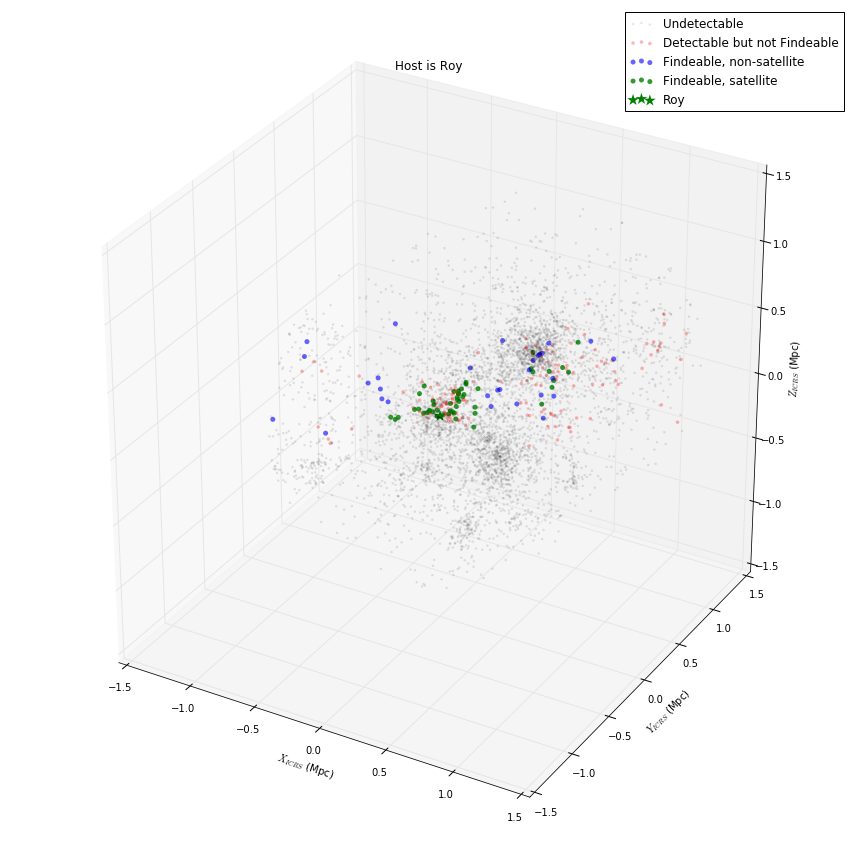

In [36]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

det = tab['detectable{}'.format(hostidx)]
find = tab['findable{}'.format(hostidx)]

plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~det
msk1 = det&~find
msk2 = find&~tab['sat_of_either']
msk3 = find&tab['sat_of_either']

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=6, alpha=.1, lw=0, label='Undetectable')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='r',s=12, alpha=.3, lw=0, label='Detectable but not Findeable')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='b',s=25, alpha=.6, lw=0, label='Findeable, non-satellite')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=25, alpha=.8, lw=0, label='Findeable, satellite')


ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)

ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

# Misc testing plots 

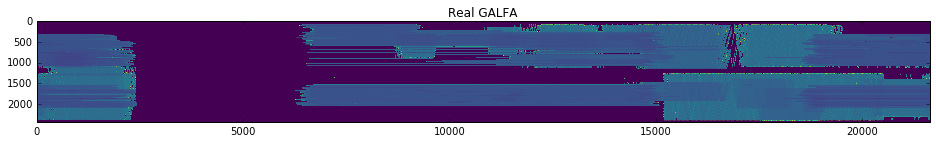

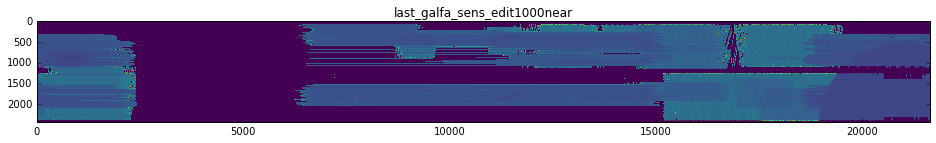

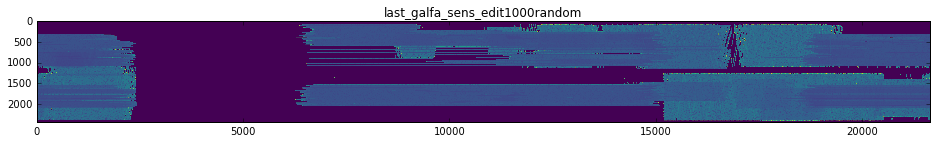

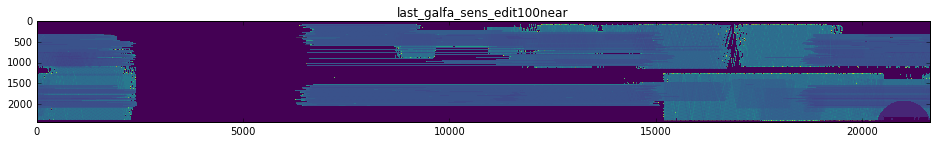

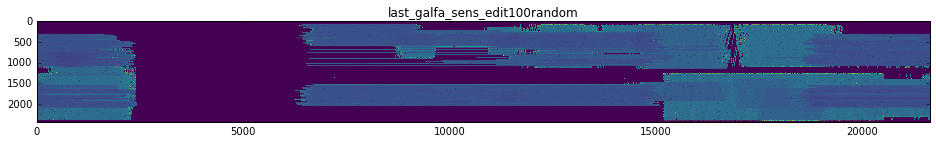

In [65]:
stretch = LogStretch() + ManualInterval(np.min(galfa_sens.value.T), np.max(galfa_sens.value.T))
baseim = stretch(galfa_sens.value.T)
galfa_edit_varnms = ['last_galfa_sens_edit1000near',
                     'last_galfa_sens_edit1000random',
                     'last_galfa_sens_edit100near',
                     'last_galfa_sens_edit100random']

plt.figure(figsize=(16,10))
plt.imshow(baseim)
plt.title('Real GALFA')
    
for varnm in galfa_edit_varnms:
    plt.figure(figsize=(16,10))
    plt.imshow(stretch(locals()[varnm][0].value.T))
    plt.title(varnm)

In [66]:
for varnm in galfa_edit_varnms:
    im = locals()[varnm][0].value.ravel()
    n4000 = np.sum((3999<im)&(im<4001))
    n12000 = np.sum((11999<im)&(im<12001))
    print(varnm, n4000, n12000, len(im))

last_galfa_sens_edit1000near 1 3600261 52609024
last_galfa_sens_edit1000random 1 3600269 52609024
last_galfa_sens_edit100near 360001 306 52609024
last_galfa_sens_edit100random 360001 303 52609024


Hooray!  Looks like the machinery is right.